In [11]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np


from pydataset import data

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# supress scientific notation
np.set_printoptions(suppress=True)

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [3]:
iris = data('iris')
iris.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa


In [4]:
iris.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width',
       'species']

In [5]:
df = iris[['petal_width', 'sepal_width']]

Like our other scikit-learn models, we'll create the instance of the k-means class, then fit it to our data. Once we've done that, we can use the object to make predictions.

In [7]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df)

kmeans.predict(df)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

The numbers output here are the groups that our K-means algorithm predicted each row to be in. Let's go ahead and store the predicted cluster back into our original dataframe.

In [8]:
iris['cluster'] = kmeans.predict(df)

In [12]:
kmeans.cluster_centers_

array([[2.05208333, 3.04166667],
       [0.24489796, 3.45102041],
       [1.30943396, 2.70754717]])

The kmeans Object
The K-means object also has a few interesting properties:

- cluster_centers_: The center point of each cluster.

- labels_: The labels for each observation.

- This is the same as what we obtained from kmeans.predict(X) above. The difference is that the predict method can be used on unseen data (for example, your test or validate data splits), while the labels_ property only contains clusters for the data used for fitting.

- intertia_: The sum of the squared errors from each data point to it's associated cluster.



These are the average values of each feature for each cluster. Putting them into a dataframe and labelling them will help illustrate:

In [14]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=df.columns)
centroids

,petal_width,sepal_width
0,2.052083,3.041667
1,0.244898,3.451020
2,1.309434,2.707547


In [15]:
iris.groupby('cluster')['petal_width', 'sepal_width'].mean()

,petal_width,sepal_width
cluster,,
0,2.052083,3.041667
1,0.244898,3.451020
2,1.309434,2.707547


these cluster centers are not data points from the dataset itself; they are the calculated average value for each group.

Text(0.5, 1.0, 'Visualizing Cluster Centers')

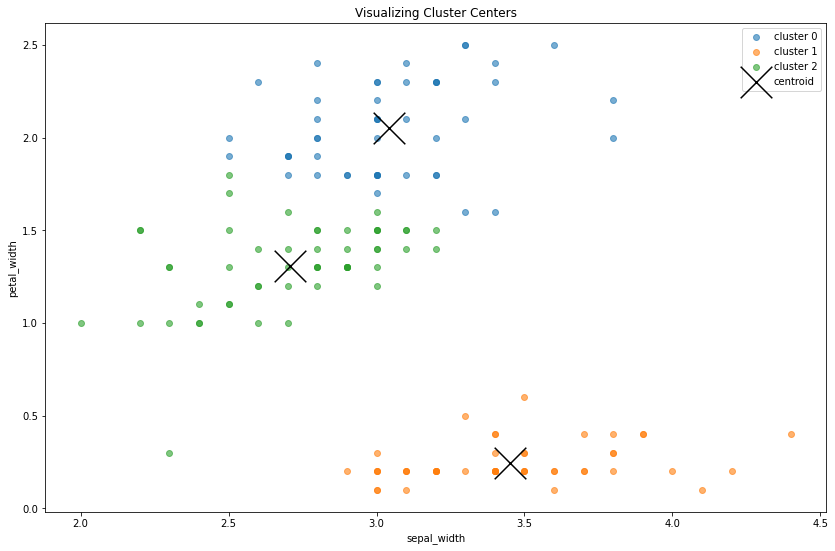

In [17]:
plt.figure(figsize=(14, 9))

for cluster, subset in iris.groupby('cluster'):
    plt.scatter(subset.sepal_width, subset.petal_width, label='cluster ' + str(cluster), alpha=.6)

centroids.plot.scatter(y='petal_width', x='sepal_width', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('sepal_width')
plt.ylabel('petal_width')
plt.title('Visualizing Cluster Centers')

Exploring Different Values of k
- Let's see what happens when we use a number of clusters that is less than optimal.

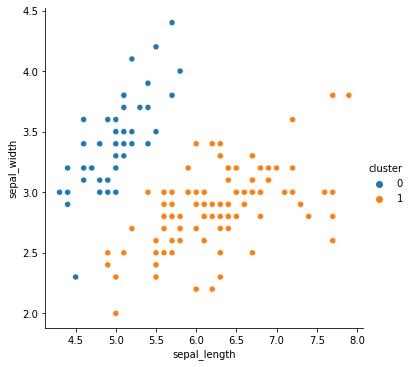

In [18]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(df)
iris['cluster'] = kmeans.predict(df)

sns.relplot(data=iris, x='sepal_length', y='sepal_width', hue='cluster')

what happens when we use a larger number "n_clusters=5"

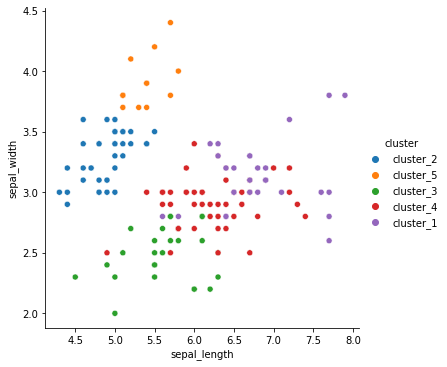

In [21]:
kmeans = KMeans(n_clusters=5).fit(df)
iris['cluster'] = kmeans.predict(df)
iris.cluster = 'cluster_' + (iris.cluster + 1).astype('str')
sns.relplot(data=iris, x='sepal_length', y='sepal_width', hue='cluster')

Choosing k with Inertia
- Within the context of k-means clustering, inertia is the sum of squared distances from each point to it's assigned centroid. We can use this quantity to help us determine a good value for k.
- Consider the case where the number of clusters is equal to the number of data points: the inertia will be 0, but our clusters don't provide any value.
- One way to choose the ideal number of clusters using inertia is the elbow method. To use the elbow method, we'll visualize the inertia against our choice in number of clusters. In this visualization, we'll look for the "elbow" of the curve, or the point where adding additional clusters doesn't give us as big of a reduction in inertia.

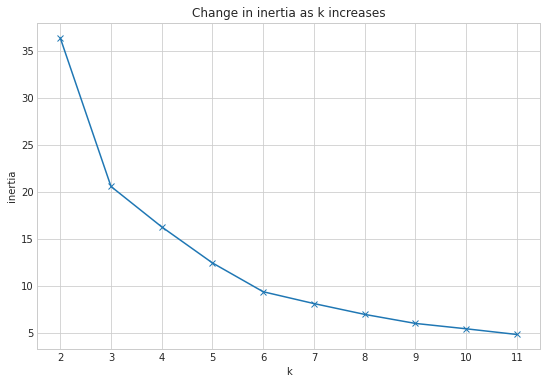

In [22]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(df).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

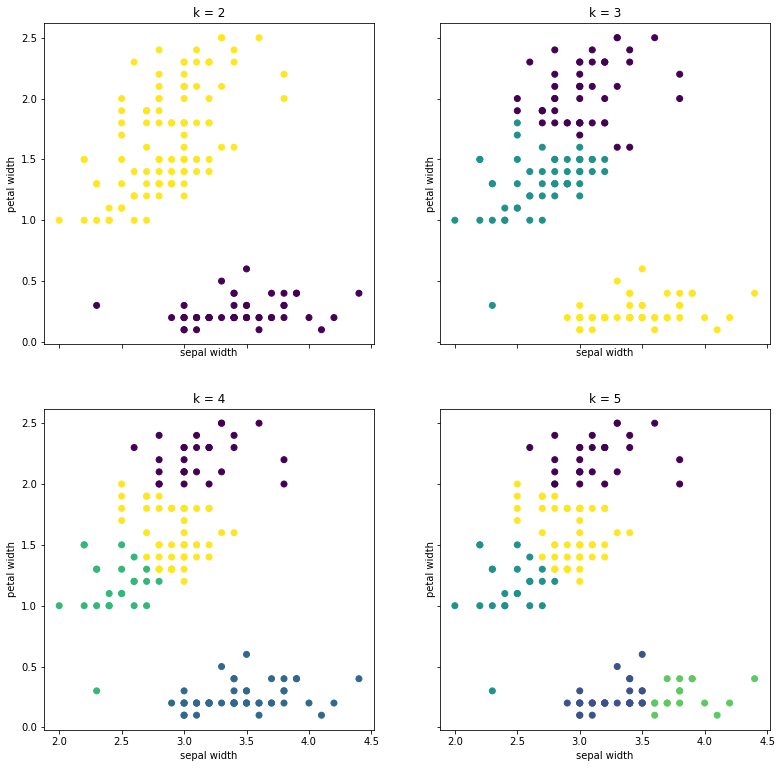

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(13, 13), sharex=True, sharey=True)

for ax, k in zip(axs.ravel(), range(2, 6)):
    clusters = KMeans(k).fit(df).predict(df)
    ax.scatter(df.sepal_width, df.petal_width, c=clusters)
    ax.set(title='k = {}'.format(k), xlabel='sepal width', ylabel='petal width')